# Exercises

In [1]:
# connect to git to load all libraries and data

# get all files from the notebook here
!rm -rf population-methods-IT
!git clone https://github.com/irenetiem/population-methods-IT

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import pickle
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath("population-methods/blob/main/02-SVM-decoding/code"))
# from utils import download_data

import urllib.request
from os import remove
import zipfile
from pathlib import Path
def download_data(url):

    if url.endswith('download'):
        URL = url
    else:
        URL = '/'.join((url, 'download'))

    if URL:
        response = urllib.request.urlopen(URL)
        data = response.read()
        response.close()

        with open('data.zip', 'wb') as f:
            f.write(data)

    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall()

    remove('data.zip')

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})


#donwload lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/NrNbvEOH7SImYLn')

from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.preprocessing import StandardScaler

Cloning into 'population-methods-IT'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 300 (delta 75), reused 35 (delta 12), pack-reused 160 (from 1)
Receiving objects: 100% (300/300), 22.31 MiB | 13.38 MiB/s, done.
Resolving deltas: 100% (143/143), done.


In [2]:
# import data
with open('data/simulated_data1.pickle', 'rb') as handle:
    data = pickle.load(handle)

spike_times = data['spike_times']
stim_onsets = data['stim_onsets']
stim_type = data['stim_type']
stim_duration = data['stim_duration']

### Exercise 1
---
Use the sklearn `make_blobs()` function, in the same way that we used in the lesson, to generate a *non linearly separable* dataset with 2 features.  
Fit a linear SVM to the dataset many times, varying the slack hyperparameter $C$, and calculate the model performance in classifying the data.  
What is, approximately, a the best value of the $C$ hyperparameter for this dataset?

In [3]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

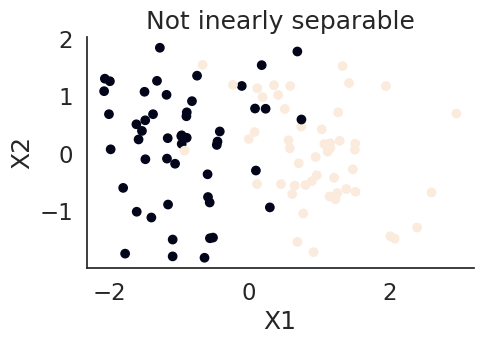

In [4]:
X_nsep,y_nsep = make_blobs(n_samples=100,n_features =2,centers=[[-1,0],[1,0]],cluster_std=.8)

X_sep,y_sep = make_blobs(n_samples=100,n_features =2,centers=[[-1,0],[1,0]],cluster_std=.3,) # also this one for the y_sep

plt.figure(figsize=(5,3))
plt.title('Not inearly separable')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(X_nsep[:,0],X_nsep[:,1],c=y_nsep)
plt.show()

In [12]:
?svm.SVC

C : float, default=1.0
    Regularization parameter. The strength of the regularization is
    inversely proportional to C. Must be strictly positive. The penalty
    is a squared l2 penalty. For an intuitive visualization of the effects
    of scaling the regularization parameter C, see
    :ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.

In [5]:
# vary hyperparameter C for this data

C_list = [0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10, 20, 40, 70]

def plot_svm(C):
  plt.figure(figsize=(5,3))
  X,y = X_nsep,y_nsep
  svc_model = svm.SVC(kernel='linear',C=C);
  svc_model.fit(X, y)

  plt.scatter(X[:,0],X[:,1],c=y_nsep)
  # Constructing a hyperplane using a formula.
  w = svc_model.coef_[0]           # w consists of 2 elements
  b = svc_model.intercept_[0]      # b consists of 1 element
  x_points = np.linspace(-2,2)    # generating x-points from -1 to 1
  y_points = -(w[0] / w[1]) * x_points - b / w[1]
  plt.plot(x_points, y_points, c='r');
  plt.scatter(svc_model.support_vectors_[:, 0],
              svc_model.support_vectors_[:, 1],
              s=50,
              c='k',
              marker='x');
  w_hat = svc_model.coef_[0] / (np.sqrt(np.sum(svc_model.coef_[0] ** 2)))
  margin = 1 / np.sqrt(np.sum(svc_model.coef_[0] ** 2))
  decision_boundary_points = np.array(list(zip(x_points, y_points)))
  points_of_line_above = decision_boundary_points + w_hat * margin
  points_of_line_below = decision_boundary_points - w_hat * margin
  plt.plot(points_of_line_above[:, 0],
          points_of_line_above[:, 1],
          'b--')
  plt.plot(points_of_line_below[:, 0],
          points_of_line_below[:, 1],
          'g--')
  plt.ylim([min(X[:,1]),max(X[:,1])])
  plt.xlabel('X1')
  plt.ylabel('X2')
  plt.title(f'C = {C}')
  plt.show()

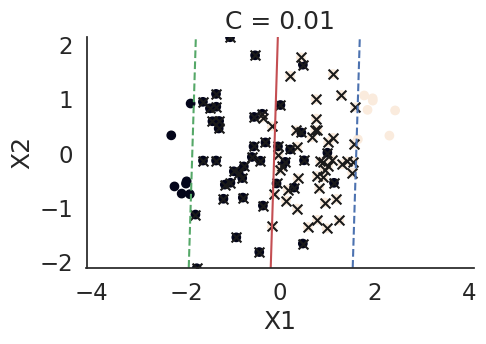

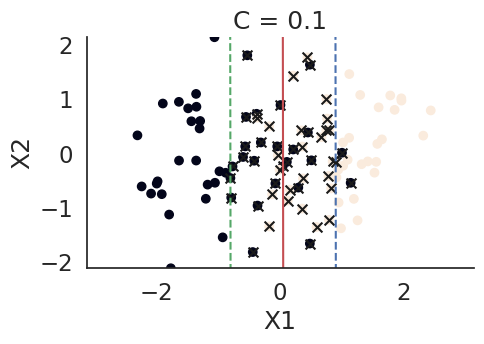

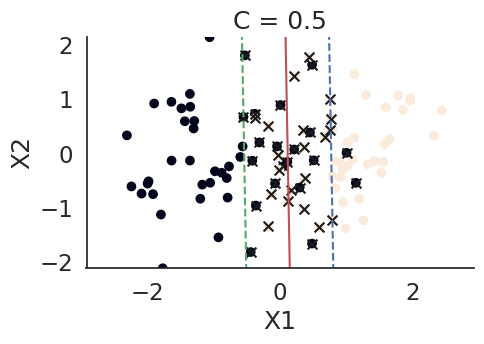

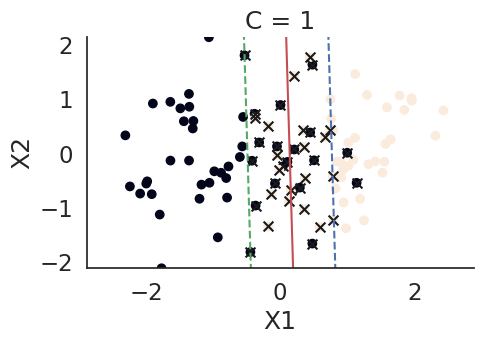

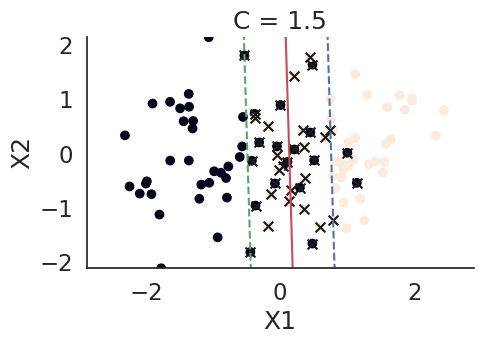

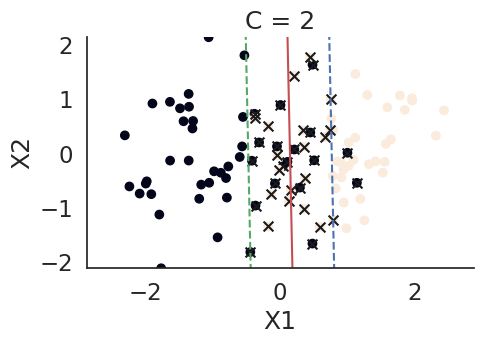

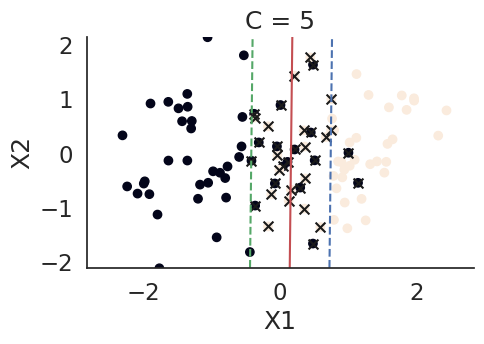

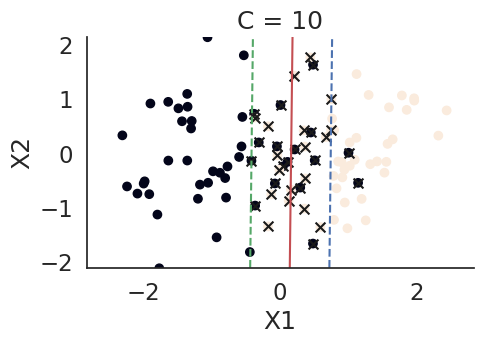

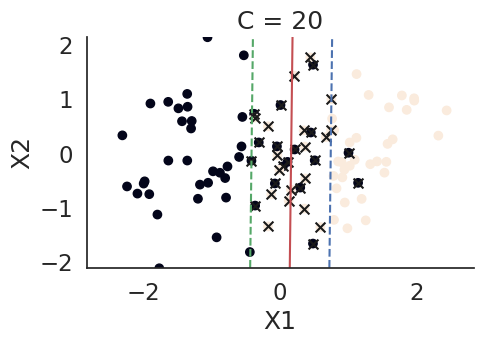

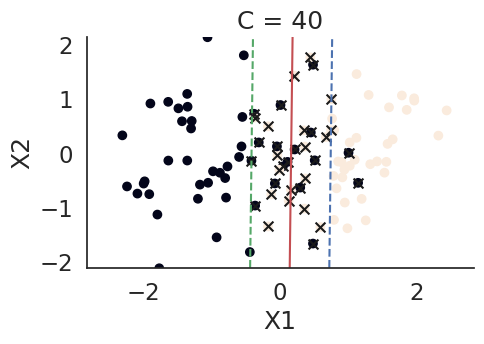

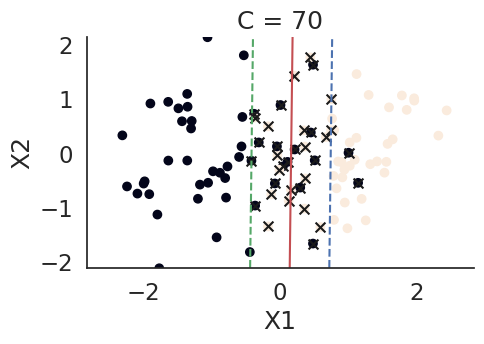

In [28]:
for C in C_list:
  plot_svm(C)

Increasing C inversely makes the margins smaller and bending the red line more to the right. A very small C gives clearly poor results, after C=5 it does not seem to change much anymore. A C of around 5 would thus be best here.

### Exercise 2
---
Repeat exercise 1, but using a non-linear SVM model (the sklearn class `SVC` uses [Radial Basis Functions](https://en.wikipedia.org/wiki/Radial_basis_function) as a default, check its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)).
To have a fairer assessment of the performance, train the model on a fraction (e.g. 80%) of the data, and test it on the other 20%.
Compare the performance of a linear SVC and a RBF SVC for dataset that are increaslingly non-linearly-separable.


### Exercise 3
---
Use the code below to simulate new data.
Generate data and then decode the stimulus identity, see how the decoding performance change when you change the following:

- The amplitude of the noise in the firing rate
- The amplitude of the stimulus modulation of the firing rate
- The number of neurons

Plot and comment.

## Useful code
---


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [31]:
# just put it all in a function

def simulate_data(amplitude_noise_in_FR = 1, amplitude_stimulus_modulation = 1, number_of_neurons = 20):
  # simulation parameters
  n_cells = number_of_neurons
  n_stim_type = 2; # number of different stimuli
  sigma_stim = amplitude_stimulus_modulation # amplitude of stimulus related modulation
  average_firing_rate = 5; # average firing rate across the population

  # generate baseline rates from exponential distirbution
  cell_rate_baseline = np.random.exponential(average_firing_rate,size=n_cells)

  # create stimulus average responses, perturbing the population firng rate profile
  # we use a multiplicative modulation in opposite directions for the two stimuli
  modulation = sigma_stim*np.random.normal(0,1,size=n_cells)
  cell_rate_stim = {1: cell_rate_baseline * (1+modulation),2:cell_rate_baseline * (1-modulation)}
  # sets negative firng rate to 0
  cell_rate_stim[1][cell_rate_stim[1]<0]=0
  cell_rate_stim[2][cell_rate_stim[2]<0]=0

  # simulate spiking activity

  s_rate = 10000 # the sampling rate of our emulated recording system
  noise_rate = amplitude_noise_in_FR # we are going to add some spike noise non related to the task
  n_stim = 100 # number of stimuli

  stim_dur = 2 #stimulus duration (in seconds)
  is_interval = 3 # interval between stimuli  (in seconds)

  stim_onsets = np.arange(0,n_stim*(stim_dur+is_interval),(stim_dur+is_interval)) # onset time of each stimulus (in seconds)
  stim_type = np.asarray([1 for i in range(int(n_stim/2))]+[2 for i in range(int(n_stim/2))]) # identity of each stimulus
  np.random.shuffle(stim_type)

  time = np.arange(0,(n_stim+1)*(stim_dur+is_interval),1.0/s_rate) # vector of the sampled times.

  spike_times = []
  for cell in range(n_cells):
      spikes = np.random.poisson(cell_rate_baseline[cell]/s_rate,size=time.shape)
      for i,stimulus in enumerate(stim_type):
          stim_idxs = np.arange(stim_onsets[i]*s_rate,(stim_onsets[i]+stim_dur)*s_rate)
          spikes[stim_idxs] = np.random.poisson(cell_rate_stim[stimulus][cell]/s_rate,size=stim_idxs.shape)

      spike_times.append(time[spikes>0])

  # save ouput
  out_dict = {'spike_times':spike_times,
              'stim_onsets':stim_onsets,
              'stim_type':stim_type,
              'stim_duration':stim_dur
              }

  with open('data/simulated_data1.pickle', 'wb') as handle:
      pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


  onset = 1 # in seconds before stimulus onset
  offset = 1 # in second after stimulus offset

  binwidth = 0.1 # in seconds (100 ms)
  bins = np.arange(-onset,stim_duration+offset+binwidth,binwidth)

  n_cells = len(spike_times)
  n_trials= len(stim_type)

  X = np.zeros((n_cells,n_trials,len(bins)-1));
  for cell in range(n_cells):
      for trial in range(n_trials):

          # selects spikes that are in trial
          sp_idx = np.logical_and(spike_times[cell]>stim_onsets[trial]-onset,
                  spike_times[cell]<stim_onsets[trial]+stim_duration+offset)

          # centers spike times around stimulus onset
          sp_cntr = spike_times[cell][sp_idx]-stim_onsets[trial]
          #bins spikes
          spike_count,_ = np.histogram(sp_cntr,bins)
          #spike_count = zscore(spike_count)
          X[cell,trial,:] = spike_count


  n_splits = 5

  avg_performance = []
  std_performance = []

  for time_bin in range(X.shape[-1]):
          # setting 2-fold cross validation
          kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
          fold_performance = []

          for train_index, test_index in kf.split(X[:,:,time_bin].T,stim_type):


                  X_train, X_test = X[:,train_index,time_bin].T, X[:,test_index,time_bin].T
                  y_train, y_test = stim_type[train_index], stim_type[test_index]

                  clf = svm.LinearSVC(max_iter=1000)
                  clf.fit(X_train, y_train)
                  fold_performance.append(clf.score(X_test,y_test))

          avg_performance.append(np.mean(fold_performance))
          std_performance.append(np.std(fold_performance))

  avg_performance = np.asarray(avg_performance)
  std_performance = np.asarray(std_performance)

  bin_centers = [(bins[i+1]+bins[i])/2 for i in range(len(bins)-1)]
  plt.plot(bin_centers,avg_performance, label = 'amplitude noise: {} \n amplitude modulation: {} \n number of neurons: {}'.format(amplitude_noise_in_FR, amplitude_stimulus_modulation, number_of_neurons))
  plt.fill_between(bin_centers,avg_performance-std_performance,
                  avg_performance+std_performance,alpha=0.2)

  plt.axhline(y=0.5,linestyle='--')#,label='chance level')
  plt.axvline(x=0,c='r')
  plt.axvline(x=2,c='r')
  # plt.title('amplitude noise: {} \n amplitude modulation: {} \n number of neurons: {}'.format(amplitude_noise_in_FR, amplitude_noise_in_FR, number_of_neurons))

  plt.legend(bbox_to_anchor=(1.1, 1.05))
  plt.xlabel('Time (s)')
  plt.ylabel('Decoding performance')

In [ ]:
# check if noise level is corerct

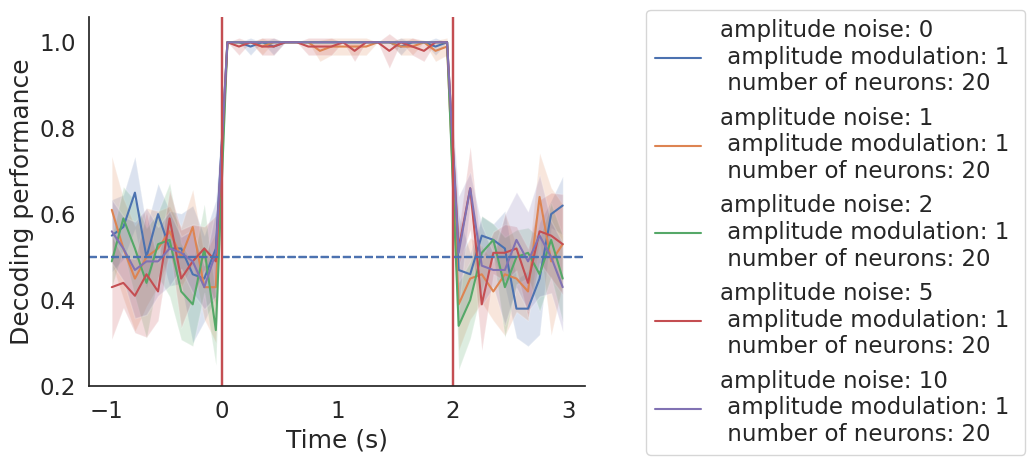

In [32]:
noise_levels = [0, 1, 2, 5, 10]
for noise_level in noise_levels:
  simulate_data(amplitude_noise_in_FR = noise_level)

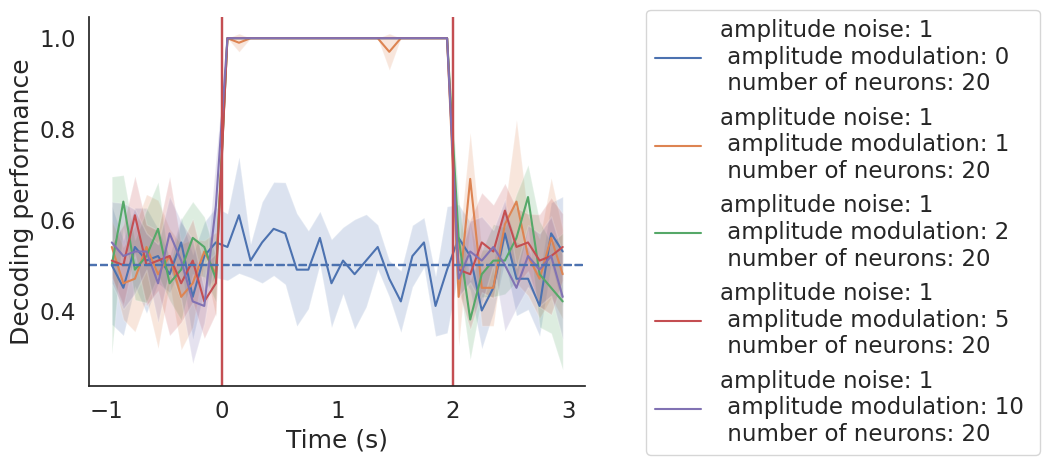

In [33]:
modulation_levels = [0, 1, 2, 5, 10]
for modulation_level in modulation_levels:
  simulate_data(amplitude_stimulus_modulation = modulation_level)

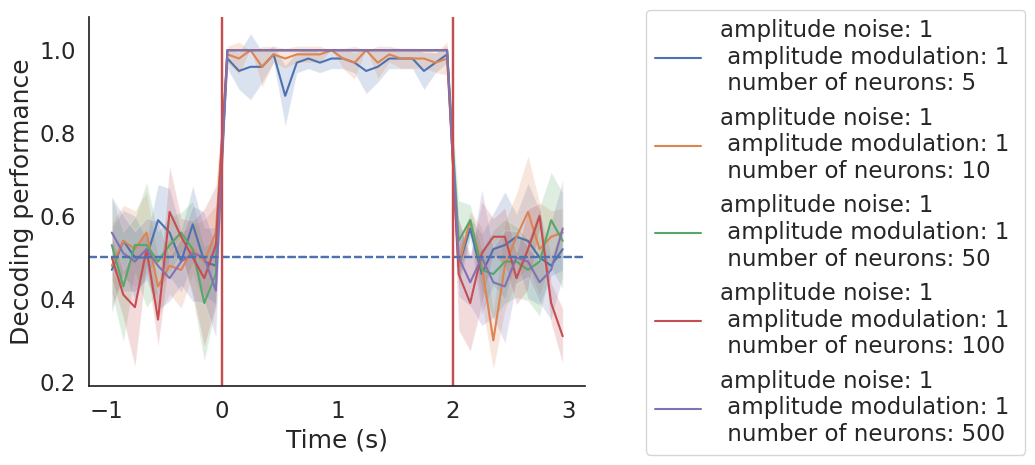

In [34]:
neuron_numbers = [5, 10, 50, 100, 500]
for neuron_number in neuron_numbers:
  simulate_data(number_of_neurons = neuron_number)